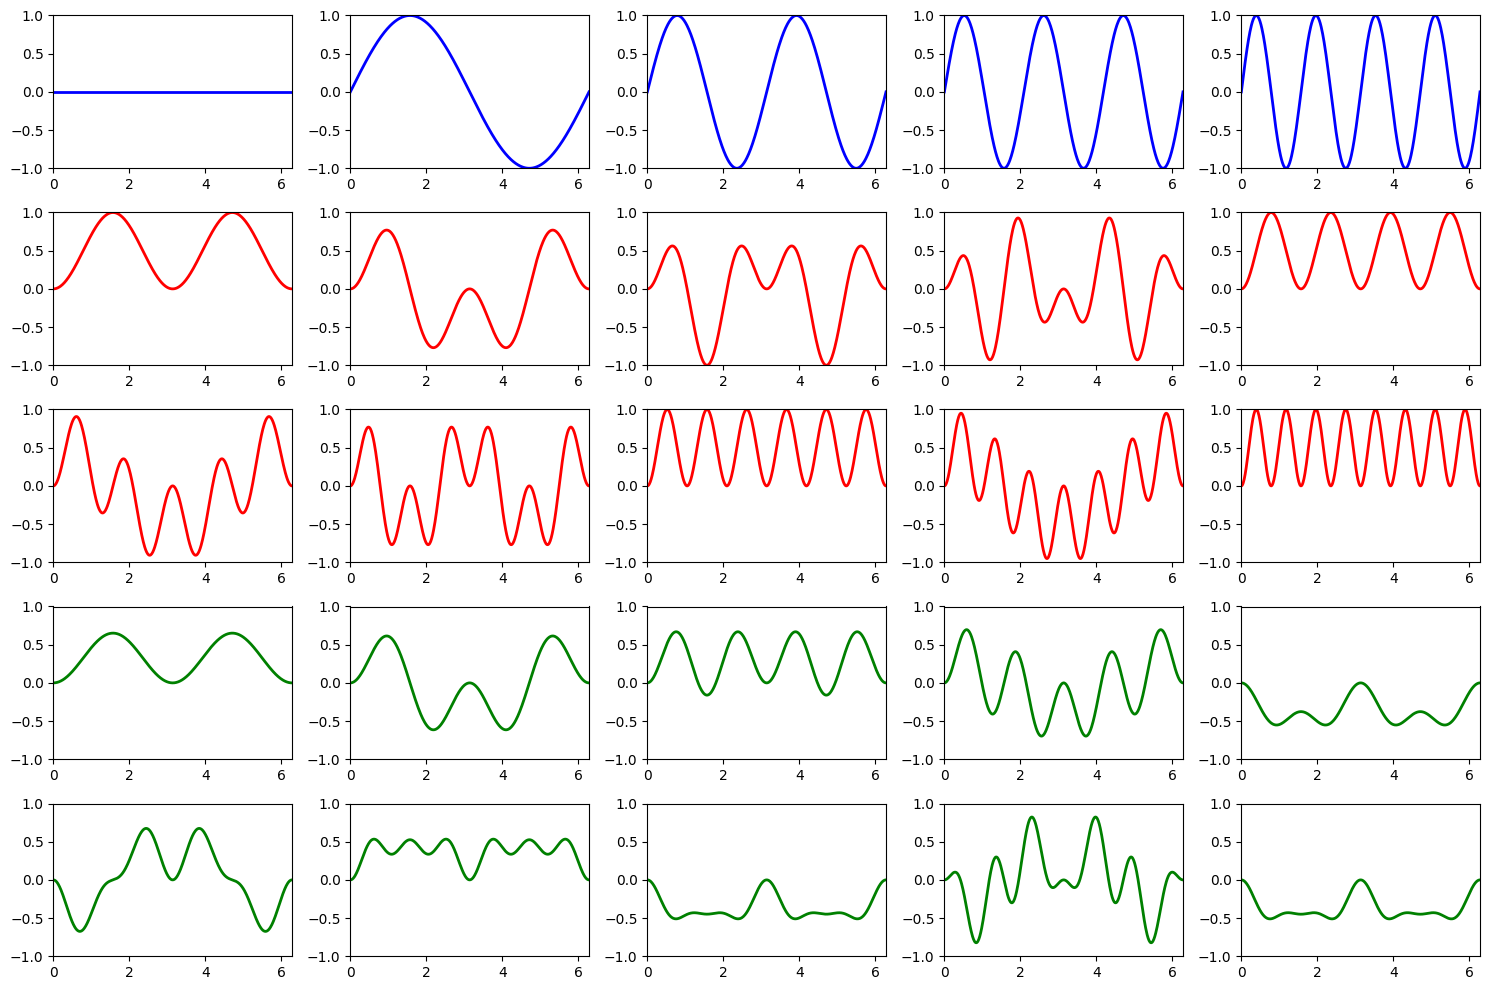

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad

# -------------------------
# Parameters
# -------------------------
MaxK = 4
PlotAnalytic = False
NumPlotPoints = 500  # Can be increased since it's now fast

# -------------------------
# Create the functions numerically using lambdas
# -------------------------
K = np.arange(0, MaxK + 1)
Phi_numeric = [lambda x, k=k: np.sin(k * x) for k in K]  # lambdas for Phi

# -------------------------
# Eigenproducts
# -------------------------
PolyPhi_numeric = []
for i in range(1, len(K)):
    for j in range(i, len(K)):
        PolyPhi_numeric.append(lambda x, i=i, j=j: Phi_numeric[i](x) * Phi_numeric[j](x))

# -------------------------
# Orthogonalization (Gram-Schmidt)
# -------------------------
Ortho_numeric = PolyPhi_numeric.copy()

def inner_product(f, g):
    return quad(lambda x: f(x) * g(x), 0, 2 * np.pi)[0]

# Gram-Schmidt process
for i in range(1, len(Ortho_numeric)):
    f = Ortho_numeric[i]
    combined_basis = Phi_numeric + Ortho_numeric[:i]
    Coeff = [inner_product(f, basis) for basis in combined_basis]
    def projection(x, Coeff=Coeff, basis=combined_basis):
        return sum(c * b(x) for c, b in zip(Coeff, basis))
    Ortho_numeric[i] = lambda x, f=f, projection=projection: f(x) - projection(x)

# Normalize
for i in range(len(Ortho_numeric)):
    norm = np.sqrt(inner_product(Ortho_numeric[i], Ortho_numeric[i]))
    Ortho_numeric[i] = lambda x, f=Ortho_numeric[i], norm=norm: f(x) / norm

# -------------------------
# Plotting
# -------------------------
X_vals = np.linspace(0, 2 * np.pi, NumPlotPoints)

def plot_function(f, X, color, pos, total, ylim_range=(-1, 1)):
    Y = f(X)
    plt.subplot(5, total, pos)
    plt.plot(X, Y, color, linewidth=2)
    plt.ylim(ylim_range)
    plt.xlim([0, 2 * np.pi])

plt.figure(figsize=(15, 10))

if PlotAnalytic:
    # Plot eigenfunctions
    for i, phi in enumerate(Phi_numeric):
        plot_function(phi, X_vals, 'b', i + 1, len(K))

    # Plot eigenproducts
    for i, poly in enumerate(PolyPhi_numeric):
        plot_function(poly, X_vals, 'r', i + 1 + len(K), len(K))

    # Plot orthogonalized eigenproducts
    for i, ortho in enumerate(Ortho_numeric):
        plot_function(ortho, X_vals, 'g', i + 1 + 3 * len(K), len(K))
else:
    # Same plotting for numerical case
    for i, phi in enumerate(Phi_numeric):
        plot_function(phi, X_vals, 'b', i + 1, len(K))

    for i, poly in enumerate(PolyPhi_numeric):
        plot_function(poly, X_vals, 'r', i + 1 + len(K), len(K))

    for i, ortho in enumerate(Ortho_numeric):
        plot_function(ortho, X_vals, 'g', i + 1 + 3 * len(K), len(K))

plt.tight_layout()
plt.show()


In [11]:
import numpy as np
import trimesh
import matplotlib.pyplot as plt
from scipy.sparse.linalg import eigsh
from scipy.sparse import csr_matrix

# -------------------------
# Parameters
# -------------------------
MeshFile = 'Meshes/bunny.off'
NumRows = 1
NumCols = 5
OrthoThresh = 1e-9
FontSize = 24

# -------------------------
# Load mesh and compute eigenfunctions
# -------------------------
print("Loading mesh and computing eigenfunctions... ")
mesh = trimesh.load_mesh(MeshFile, file_type='off')
vertices = mesh.vertices
faces = mesh.faces

# Assuming you have your FEM operator functions
from your_utils.mesh_processing import compute_fem_matrices, compute_eigenfunctions
from your_utils.orthogonalization import compute_eigenproducts, orthogonalize_basis
from your_utils.plotting import plot_scalar_map

NumFuncs = NumRows * NumCols

# FEM stiffness and mass matrices (with Dirichlet BC assumed)
S, A = compute_fem_matrices(vertices, faces, order=1, bc='Dirichlet')

# Eigen decomposition (shift-invert for smallest eigenvalues)
Lambda, Phi = eigsh(S, M=NumFuncs, sigma=-1e-5, which='LM', OPinv=A)
Lambda = np.real(Lambda)
Phi = np.real(Phi)

# -------------------------
# Compute eigenproducts
# -------------------------
print("Computing eigenproducts... ")
PolyPhi = compute_eigenproducts(Phi, order=2, include_linear=False)

# -------------------------
# Orthogonalization
# -------------------------
print("Orthogonalization... ")
Q, R = orthogonalize_basis(A, PolyPhi, thresh=OrthoThresh, verbose=True)

# -------------------------
# Plotting
# -------------------------
plt.figure(figsize=(20, 10))
TotalPlots = 3 * NumRows * NumCols

# Plot eigenfunctions
for i in range(NumRows):
    for j in range(NumCols):
        Idx = i * NumCols + j
        plt.subplot(3 * NumRows, NumCols, Idx + 1)
        plot_scalar_map(mesh, Phi[:, Idx], cmap='bwr', colorbar=True)
        plt.title(f"$\\varphi_{{{Idx}}}$", fontsize=FontSize)

# Plot eigenproducts
for i in range(NumRows):
    for j in range(NumCols):
        Idx = i * NumCols + j
        plt.subplot(3 * NumRows, NumCols, NumRows * NumCols + Idx + 1)
        plot_scalar_map(mesh, PolyPhi[:, NumFuncs + Idx], cmap='bwr', colorbar=True)
        Idx1 = Idx // NumFuncs + 1
        Idx2 = (Idx % NumFuncs) + 2 * (Idx1 - 1)
        plt.title(f"$\\varphi_{{{Idx1}}}\\varphi_{{{Idx2}}}$", fontsize=FontSize)

# Plot orthogonalized eigenproducts
for i in range(NumRows):
    for j in range(NumCols):
        Idx = i * NumCols + j
        plt.subplot(3 * NumRows, NumCols, 2 * NumRows * NumCols + Idx + 1)
        plot_scalar_map(mesh, Q[:, NumFuncs + Idx], cmap='bwr', colorbar=True)
        plt.title(f"$Q_{{{Idx}}}$", fontsize=FontSize)

plt.tight_layout()
plt.show()


Loading mesh and computing eigenfunctions... 


AttributeError: 'str' object has no attribute 'read'

In [5]:
!pip install trimesh

  Using cached trimesh-4.6.9-py3-none-any.whl.metadata (18 kB)
Using cached trimesh-4.6.9-py3-none-any.whl (711 kB)



[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip
